<a href="https://colab.research.google.com/github/Foxy1987/neuroGLM/blob/master/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [4]:
import sys
sys.path.append('/content/drive/My Drive/Work Stuff/postdoc stuff/temporal filtering project/GLM/neuroGLM/')


In [ ]:
from google.colab import files
uploaded = files.upload()

In [30]:
from glmtools.make_xdsgn import DesignMatrix, Experiment, DesignSpec
import utils.read as io
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from glmtools.fit import neg_log_lik

In [38]:
stim, sptimes = io.load_spk_times('stim.txt', 'pn1SpTimes_reverseChirp.mat', 5, 30)
trials = len(sptimes)
duration = 25

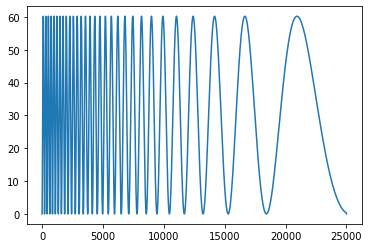

In [39]:
plt.plot(stim)

In [40]:
stim = (stim / np.max(stim))*0.01

# Bin the spike times
Now we will bin the spike times using the same time bin size used for the stimulus. We will use the time bin centers to bin the spike train.


In [43]:
dt = 0.001
sp_count_fun = lambda x: np.histogram(x, np.arange(0.5, len(stim)+1) * dt - dt)[0] 
sps = list(map(sp_count_fun, sptimes))    # apply the binning function sp_count_fun to each trial
stim_ = np.tile(stim, (trials, 1))        # we need a stim for every trial


(5, 25000)


# Create an experiment object 
Now we will make an experiment object to hold response variable and to register the types of regressors in the experiment

In [44]:
# make an Experiment object
expt = Experiment(dt, duration, stim=stim_, sptimes=sps)

# register continuous external regressor
expt.registerContinuous('stim')

# register internal sptrain regressor
expt.register_spike_train('sptrain')

# Create a design specification object
This object holds all the information about how to construct the design matrix for each regressor. The function compile_design_matrix_from_trial_indices() stacks design matrices for a given regressor and for each trial on top of one another. 

In [45]:
trial_inds = list(range(len(sptimes)))
dspec = DesignSpec(expt, trial_inds)

# add stim and spike history regressors
dspec.addRegressorContinuous()
dspec.addRegressorSpTrain()

## Build the design matrix and view the contents
Now we use the information about each regressor included in the experiment and the number of trials to construct a design matrix

In [46]:
dm, X, y = dspec.compileDesignMatrixFromTrialIndices()

forming design matrix from trial indices
forming design matrix from trial indices
convolving padded stimulus with raised cosine basis functions
convolving padded stimulus with raised cosine basis functions
forming design matrix from trial indices
forming design matrix from trial indices
convolving padded stimulus with raised cosine basis functions
convolving padded stimulus with raised cosine basis functions
forming design matrix from trial indices
forming design matrix from trial indices
convolving padded stimulus with raised cosine basis functions
convolving padded stimulus with raised cosine basis functions
forming design matrix from trial indices
forming design matrix from trial indices
convolving padded stimulus with raised cosine basis functions
convolving padded stimulus with raised cosine basis functions
forming design matrix from trial indices
forming design matrix from trial indices
convolving padded stimulus with raised cosine basis functions
convolving padded stimulus with 

## Section 2.1: Nonlinear optimization with `scipy.optimize
We will use scipy.optimize.minimize to compute maximum likelihood estimates for the filter weights in the Poissson GLM model with an exponential nonlinearity.

We defined an *objective function* called neg_log_lik that takes as input a design matrix, a spike count vector, and a vector of parameters and returns a negative log likelihood.

What should the objective function look like? We want it to return the negative log likelihood: $-\log P(y \mid X, \theta).$

In the Poisson GLM,

$$
\log P(\mathbf{y} \mid X, \theta) = \sum_t \log P(y_t \mid \mathbf{x_t},\theta),
$$

where

$$ P(y_t \mid \mathbf{x_t}, \theta) = \frac{\lambda_t^{y_t}\exp(-\lambda_t)}{y_t!} \text{, with rate } \lambda_t = \exp(\mathbf{x_t}^{\top} \theta).$$

Now, taking the log likelihood for all the data we obtain:
$\log P(\mathbf{y} \mid X, \theta) = \sum_t( y_t \log(\lambda_t) - \lambda_t - \log(y_t !)).$

Because we are going to minimize the negative log likelihood with respct to the parameters $\theta$, we can ignore the last term that does not depend on $\theta$. For faster implementation, let us rewrite this in matrix notation:

$$\mathbf{y}^T \log(\mathbf{\lambda}) - \mathbf{1}^T \mathbf{\lambda} \text{, with  rate } \mathbf{\lambda} = \exp(X^{\top} \theta)$$

Finally, don't forget to add the minus sign for your function to return the negative log likelihood.

 Use a random vector of weights to start (mean 0, sd .2) and call the minimize function

In [47]:
prs = [0.0, -16.9989, 4.5455, 1.1125, 0.8270, -1.3354]
ih_pars = np.random.normal(0, .2,  8)
prs = np.concatenate((prs, ih_pars), axis=0)
res = minimize(neg_log_lik, prs, args=(5, X, y, 1),
										options={'maxiter': 1000, 'disp': True})
print(prs)
theta_ml = res['x']

         Current function value: -6082.588968
         Iterations: 30
         Function evaluations: 897
         Gradient evaluations: 56
[ 0.00000000e+00 -1.69989000e+01  4.54550000e+00  1.11250000e+00
  8.27000000e-01 -1.33540000e+00 -4.21164044e-03  2.22805794e-01
  2.49980118e-01 -3.89317259e-01  1.89958103e-01  1.31257187e-01
 -4.51964073e-01  6.29063631e-02]


# Combine the weights across the basis functions for each filter
Now we need to combine the weights across each of the basis functions to get the stimulus filter and post-spike filter. These filters are saved in a dictionary for easy access.

In [48]:
# combine weights across each basis vector
d = dm.get_regressor_from_output(theta_ml)

dc = theta_ml[0]
k = d['stim'][1]
kt = d['stim'][0] * dt
h = d['sptrain'][1]
ht = d['sptrain'][0] * dt

## Plot the stimulus filter and the postspike filter

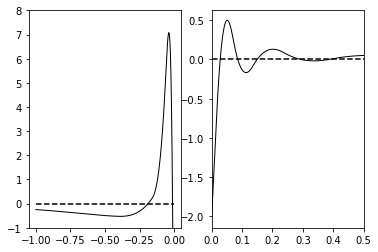

In [52]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(kt, k, '-k', linewidth=1)
ax2.plot(ht, h, '-k', linewidth=1)
ax1.plot([-1, 0], [0, 0], '--k')
ax2.plot([0, .5], [0, 0], '--k')
ax2.set_xlim(0, 0.5)
ax1.set_ylim(-1, 8)
plt.show()